In [123]:
import pandas as pd
import os
import numpy as np
import json
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE,RFECV,SelectKBest
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as acc
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

from feature_selection import *
from unsupervised_analysis import plot_PCA_2D, PCA_transform_data
from cycifsuite.get_data import read_synapse_file
from rfpimp import importances
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
path = 'd:/data/MCF10A 090718 data/'
feature_files = [x for x in os.listdir(path) if ('plate_2_txt_' in x) and 'all' not in x]
sample_size=None
pooled_metadata = pd.read_csv(read_synapse_file('syn17902177'),index_col=0)
with open('d:/data/MCF10A 090718 data/feature_metadata.json') as f:
    data=json.load(f)
feature_meta = pd.DataFrame.from_dict(data).transpose()
feature_meta = feature_meta.loc[[x for x in feature_meta.index if 'cellpos' not in x]]
print(feature_files)

Welcome, Yunguan Wang!

['plate_2_txt_features_BMP2.hdf', 'plate_2_txt_features_EGF.hdf', 'plate_2_txt_features_HGF.hdf', 'plate_2_txt_features_IFNG.hdf', 'plate_2_txt_features_OSM.hdf', 'plate_2_txt_features_PBS.hdf', 'plate_2_txt_features_TGFB.hdf']


# Getting some simple stats on data, e.g., std, cv
Since Anova is fast, ran it on all data instead of sampled data.
Read full data just for anova.
#### Figure 1A std histogram and 1B ANOVA.

In [ ]:
x, y = make_x_and_y(path, feature_files)
_,sk = selct_k_anova(x,y,x.shape[1])
plot_feature_var(x, y, sk, feature_meta)
del x, y

# Read and bin the data well-wise
#### **Note: Scaling for PCA**
PCA to test if the centroids are separable in various feature spaces.
#### Figure 2

In [156]:
# x_binned, y_binned = make_x_and_y(path, feature_files, binning=True, metadata=pooled_metadata)
plot_binned_pca_plot(x_binned, y_binned, figsize=(8,5), figname='p2 PCA 2D scatter all features.png')
plot_feature_wise_pca(x_binned, y_binned,  feature_meta, figsize=(8,5), save_fig='p2')

## Evaluate full model and models with different cat of features

In [104]:
x_train, x_test, y_train, y_test = make_x_and_y(path, feature_files,sample_size=sample_size, test_size=0.20)
full_model = RandomForestClassifier(100)
full_model.fit(x_train, y_train)
y_pred = full_model.predict(x_test)
print('Full feature accuracy {}'.format(acc(y_test, y_pred)))

processing plate_2_txt_features_BMP2.hdf
processing plate_2_txt_features_EGF.hdf
processing plate_2_txt_features_HGF.hdf
processing plate_2_txt_features_IFNG.hdf
processing plate_2_txt_features_OSM.hdf
processing plate_2_txt_features_PBS.hdf
processing plate_2_txt_features_TGFB.hdf
Full feature accuracy 0.7103734439834025


In [205]:
# os.chdir('Results/Feature selection/plate 2/')
# Evaluate feature importances in different categories
rf_feature_imp_plot(full_model, feature_meta, x_train.columns, savefig_prefix='p2')
# stats = feature_meta.loc[feature_meta.marker=='stat3']
for meta_col in ['feature_chr','marker']:
    if not os.path.exists(meta_col):
        os.mkdir(meta_col)
    for j in feature_meta[meta_col].dropna().unique():
        prefix = (meta_col + '/p2 ' + j).replace('|','')
        new_f_meta = feature_meta.loc[feature_meta[meta_col]==j].dropna()
        if new_f_meta.shape[0]==0:
            continue
        f_meta_cols = [x for x in ['a_feature_type','feature_chr', 'marker', 'sublocation'] if x!=key]
        rf_feature_imp_plot(full_model, new_f_meta, x_train.columns, feature_meta_cols=f_meta_cols, savefig_prefix=prefix, title=j)

In [190]:
"""Define sets of features
"""
feature_sets = pd.Series()
for feature_set_name in feature_meta.a_feature_type.unique():
    feature_list = feature_meta[feature_meta.a_feature_type==feature_set_name].index.tolist()
    feature_sets[feature_set_name] = feature_list
# old_int features
feature_list = [k for k in x_train.columns if '_int_' in k]    
feature_list = [k for k in feature_list if 'mean' in k]
feature_list = [k for k in feature_list if k.split('_')[-1] in ['nuc','cyto']]
feature_sets['old_int'] = feature_list
# mean, standev
feature_list = feature_meta[feature_meta.feature_chr.isin(['mean','standev'])].index.tolist()
feature_sets['mean+sd'] = feature_list
feature_sets['all'] = feature_meta.index.tolist()

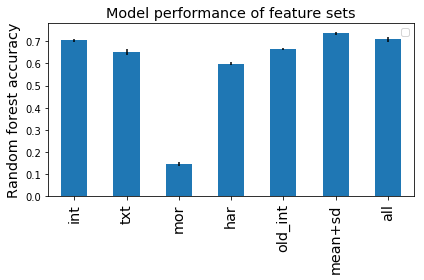

In [195]:
cat_model = RandomForestClassifier(100)
model_stats = pd.DataFrame()
for i in feature_sets.index:
    feature_list = feature_sets[i]
    feature_list = [x for x in feature_list if x in x_train.columns]
    rf_cv = cross_val_score(cat_model, x_train[feature_list], y_train,scoring='accuracy', cv=5,n_jobs=4)
    model_stats.loc['mean',i] = rf_cv.mean()
    model_stats.loc['sd',i] = rf_cv.std()
    print('CV accurary with feature category {} with {} features : {:.2f}'.format(i, len(feature_list), rf_cv.mean()))
# plotting
model_stats.transpose().plot(kind='bar',yerr='sd')
plt.ylabel('Random forest accuracy', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.title('Model performance of feature sets',fontsize='x-large')
plt.legend('')
plt.tight_layout()
plt.savefig('Model performance of feature sets.png')

### Evaluate the single cell level data on morphology feature. (10% sampled data)

In [ ]:
# pca=PCA(2)
# feature_list = [k for k in x_train.columns if 'mor' in k]
# pca_x = pca.fit_transform(x_train[feature_list])
# pca_x = pd.DataFrame(pca_x, columns=['pc1','pc2'])
# pca_x['ligand'] = y_train
# sns.scatterplot('pc1','pc2',data=pca_x,hue='ligand')
# plt.title('10 morphology feature', fontsize=18)